In [1]:
# DS Modules
import numpy as np
import pandas as pd

# Visualization modules
import matplotlib.pyplot as plt
import seaborn as sns

# Helpers
import helpers
import wrangle
import model

In this notebook we will be looking at the prediction problem through the lense of a classification modeling problem.  To tackle this problem we will be taking a few different approaches.

- Treating the quality score as a category
- Treating quality scores 7, 8, and 9 as a "good wine" category
- Treating quality scores less than 5 as a "bad wines" category


In [2]:
r = wrangle.wrangle_data('red')
tr, sr, vr = helpers.prep.train_test_validate_split(r)

In [3]:
w = wrangle.wrangle_data('white')
tw, sw, vw = helpers.prep.train_test_validate_split(w)

In [4]:
frames = [tr, sr, vr, tw, sw, vw]
reds = [tr, sr, vr]
whites = [tw, sw, vw]

### Clusters

In [5]:
rclst = model.FlavorProfile()
rclst.fit(tr)
tr['flavor_profile'] = rclst.predict(tr)
sr['flavor_profile'] = rclst.predict(sr)
vr['flavor_profile'] = rclst.predict(vr)
wclst = model.FlavorProfile()
wclst.fit(tw)
tw['flavor_profile'] = rclst.predict(tw)
sw['flavor_profile'] = rclst.predict(sw)
vw['flavor_profile'] = rclst.predict(vw)

### Vinegar categories


In [6]:
bins = [-np.inf, 0.6, 1.2, np.inf]
labels = ['undetectable','noticeable','strong']

for df in frames:
    df['flavor_vinegar'] = pd.cut(df.volatile_acidity, bins=bins, labels=labels)

### One hot encoding pipeline

In [7]:
target = 'quality'
cat_feats = [
    'flavor_profile',
    'flavor_vinegar',
]
num_feats = [
    'fixed_acidity', 
    'volatile_acidity', 
    'citric_acid', 
    'residual_sugar',
    'chlorides', 
    'free_sulfur_dioxide', 
    'total_sulfur_dioxide', 
    'density',
    'ph', 
    'sulphates', 
    'alcohol',
]

In [8]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(tr[cat_feats])
temp = encoder.transform(tr[cat_feats])

In [9]:
def train_onehot_encoder(df, cats):
    from sklearn.preprocessing import OneHotEncoder
    encoder = OneHotEncoder(handle_unknown='ignore')
    encoder.fit(df[cats])
    return encoder

In [10]:
temp.todense()

matrix([[0., 0., 1., ..., 1., 0., 0.],
        [0., 1., 0., ..., 0., 0., 1.],
        [0., 1., 0., ..., 0., 0., 1.],
        ...,
        [0., 1., 0., ..., 0., 0., 1.],
        [1., 0., 0., ..., 0., 0., 1.],
        [1., 0., 0., ..., 0., 0., 1.]])

In [11]:
encoder.get_feature_names_out()

array(['flavor_profile_0', 'flavor_profile_1', 'flavor_profile_2',
       'flavor_profile_3', 'flavor_vinegar_noticeable',
       'flavor_vinegar_strong', 'flavor_vinegar_undetectable'],
      dtype=object)

In [12]:
cats = pd.DataFrame(temp.todense(),columns = encoder.get_feature_names_out())
cats

,flavor_profile_0,flavor_profile_1,flavor_profile_2,flavor_profile_3,flavor_vinegar_noticeable,flavor_vinegar_strong,flavor_vinegar_undetectable
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...
810,0.0,0.0,1.0,0.0,0.0,0.0,1.0
811,1.0,0.0,0.0,0.0,0.0,0.0,1.0
812,0.0,1.0,0.0,0.0,0.0,0.0,1.0
813,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [13]:
tr.index

Int64Index([  38,   54,  138,  779, 1559,  248,  261,  908,  640,  389,
            ...
             127,  970, 1302,   52, 1000,  152, 1156,  149,  413,  518],
           dtype='int64', length=815)

In [14]:
xf = pd.concat([tr[num_feats], cats.set_index(tr.index)], axis=1)

In [15]:
scaler = helpers.prep.train_scaler(xf)

xf = helpers.prep.scale_df(xf, scaler)

In [16]:
xf.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,flavor_profile_0,flavor_profile_1,flavor_profile_2,flavor_profile_3,flavor_vinegar_noticeable,flavor_vinegar_strong,flavor_vinegar_undetectable
38,0.089286,0.829060,0.09,0.041096,0.239168,0.084507,0.045936,0.300459,0.598425,0.067485,0.215385,0.0,0.0,1.0,0.0,1.0,0.0,0.0
54,0.258929,0.299145,0.15,0.130137,0.131716,0.450704,0.236749,0.415138,0.338583,0.159509,0.276923,0.0,1.0,0.0,0.0,0.0,0.0,1.0
138,0.276786,0.341880,0.19,0.082192,0.081456,0.197183,0.349823,0.468654,0.464567,0.104294,0.169231,0.0,1.0,0.0,0.0,0.0,0.0,1.0
779,0.214286,0.307692,0.03,0.116438,0.072790,0.281690,0.303887,0.564220,0.598425,0.141104,0.215385,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1559,0.276786,0.376068,0.26,0.075342,0.079723,0.422535,0.441696,0.470183,0.370079,0.092025,0.230769,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [17]:
config_obj = {
    'target' : 'quality',
    'cat_feats' : [
        'flavor_profile',
        'flavor_vinegar',
    ],
    'num_feats' : [
        'fixed_acidity', 
        'volatile_acidity', 
        'citric_acid', 
        'residual_sugar',
        'chlorides', 
        'free_sulfur_dioxide', 
        'total_sulfur_dioxide', 
        'density',
        'ph', 
        'sulphates', 
        'alcohol',
    ],
}

def prep_frame(df, encoder, scaler, config):
    '''Converts a raw dataframe to a dictionary with model ready 'X' and 'y' variables.
    '''
    target = config['target']
    cat_feats = config['cat_feats']
    num_feats = config['num_feats']
    
    y = df[target]

    temp = encoder.transform(df[cat_feats])
    cats = pd.DataFrame(temp.todense(),columns = encoder.get_feature_names_out())
    xf = pd.concat([df[num_feats], cats.set_index(df.index)], axis=1)

    xf = helpers.prep.scale_df(xf, scaler)

    out = {
        'X' : xf,
        'y' : y
    }

    return out

In [18]:
d = prep_frame(tr, encoder, scaler, config_obj)
d['X']

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,flavor_profile_0,flavor_profile_1,flavor_profile_2,flavor_profile_3,flavor_vinegar_noticeable,flavor_vinegar_strong,flavor_vinegar_undetectable
38,0.089286,0.829060,0.09,0.041096,0.239168,0.084507,0.045936,0.300459,0.598425,0.067485,0.215385,0.0,0.0,1.0,0.0,1.0,0.0,0.0
54,0.258929,0.299145,0.15,0.130137,0.131716,0.450704,0.236749,0.415138,0.338583,0.159509,0.276923,0.0,1.0,0.0,0.0,0.0,0.0,1.0
138,0.276786,0.341880,0.19,0.082192,0.081456,0.197183,0.349823,0.468654,0.464567,0.104294,0.169231,0.0,1.0,0.0,0.0,0.0,0.0,1.0
779,0.214286,0.307692,0.03,0.116438,0.072790,0.281690,0.303887,0.564220,0.598425,0.141104,0.215385,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1559,0.276786,0.376068,0.26,0.075342,0.079723,0.422535,0.441696,0.470183,0.370079,0.092025,0.230769,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,0.250000,0.376068,0.03,0.061644,0.105719,0.338028,0.328622,0.376911,0.480315,0.104294,0.261538,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1156,0.339286,0.017094,0.51,0.058219,0.064125,0.619718,0.289753,0.395260,0.464567,0.239264,0.523077,1.0,0.0,0.0,0.0,0.0,0.0,1.0
149,0.312500,0.205128,0.44,0.130137,0.095321,0.140845,0.130742,0.568043,0.622047,0.147239,0.323077,0.0,1.0,0.0,0.0,0.0,0.0,1.0
413,0.464286,0.205128,0.53,0.397260,0.109185,0.070423,0.045936,0.652141,0.417323,0.276074,0.507692,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [19]:
v = prep_frame(vr, encoder, scaler, config_obj)

# Red wine modeling

### Red Fitting pipeline

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from xgboost import XGBRFClassifier
from helpers.eval import BaselineModel

models = {
    "Mode" : BaselineModel(method='mode'),
    # "KNN - 3": KNeighborsClassifier(n_neighbors=3),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear SVM": SVC(C=0.025, kernel="linear"),
    "RBF SVM": SVC(C=1, gamma=2),
    "Gaussian Process": GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1)),
    # "Decision Tree": DecisionTreeClassifier(max_depth=5),
    # "Random Forest": RandomForestClassifier(max_depth=5, max_features=1, n_estimators=10),
    # "XG Boost": XGBClassifier(),
    # "XGRF": XGBRFClassifier(),
    "Neural Net": MLPClassifier(alpha=1, max_iter=1000),
    "AdaBoost": AdaBoostClassifier(),
    "Naive Bayes": GaussianNB(),
    # "QDA": QuadraticDiscriminantAnalysis(),
    }

In [21]:
for k in range(1,16):
    models[f"KNN_{k}"] = KNeighborsClassifier(n_neighbors=k)
for k in range(1,16):
    models[f'Decision Tree_{k}'] = DecisionTreeClassifier(max_depth=k)
for k in range(1,16):
    models[f"Random Forest_{k}"] = RandomForestClassifier(max_depth=k)

In [22]:
import time
for name, model in models.items():
    # time.sleep(1)
    start_time = time.time()
    model.fit(d['X'], d['y'])
    stop_time = time.time()
    print(f'Fit {name} in {stop_time-start_time}')

Fit Mode in 0.0010025501251220703
Fit Logistic Regression in 0.059998512268066406
Fit Linear SVM in 0.03203558921813965
Fit RBF SVM in 0.06399774551391602
Fit Gaussian Process in 48.1744601726532
Fit Neural Net in 1.2349982261657715
Fit AdaBoost in 0.12355399131774902
Fit Naive Bayes in 0.0020008087158203125
Fit KNN_1 in 0.002016782760620117
Fit KNN_2 in 0.001972675323486328
Fit KNN_3 in 0.00099945068359375
Fit KNN_4 in 0.002001047134399414
Fit KNN_5 in 0.0020072460174560547
Fit KNN_6 in 0.0009927749633789062
Fit KNN_7 in 0.0019998550415039062
Fit KNN_8 in 0.00099945068359375
Fit KNN_9 in 0.0020008087158203125
Fit KNN_10 in 0.0009992122650146484
Fit KNN_11 in 0.0019998550415039062
Fit KNN_12 in 0.0009999275207519531
Fit KNN_13 in 0.0020008087158203125
Fit KNN_14 in 0.0029981136322021484
Fit KNN_15 in 0.0020012855529785156
Fit Decision Tree_1 in 0.0019996166229248047
Fit Decision Tree_2 in 0.0030002593994140625
Fit Decision Tree_3 in 0.0025205612182617188
Fit Decision Tree_4 in 0.003995

### Red Scoring

In [23]:
from sklearn.metrics import accuracy_score, mean_squared_error, max_error
scores = {}
for name, model in models.items():
    # time.sleep(1)
    start_time = time.time()
    tp = model.predict(d['X'])
    vp = model.predict(v['X'])
    scores[f'red_{name}'] = {
        'train_acc': accuracy_score(d['y'], tp),
        'validate_acc': accuracy_score(v['y'], vp),
        'train_rmse' : mean_squared_error(d['y'], tp, squared=False),
        'validate_rmse' : mean_squared_error(v['y'], vp, squared=False),
        'train_max_error': max_error(d['y'], tp),
        'validate_max_error': max_error(v['y'], vp),
        'tp': tp,
        'vp': vp
    }
    stop_time = time.time()
    print(f'{name} predicted in {stop_time-start_time}')

Mode predicted in 0.0030019283294677734
Logistic Regression predicted in 0.00500178337097168
Linear SVM predicted in 0.03299593925476074
RBF SVM predicted in 0.10854315757751465
Gaussian Process predicted in 0.8080909252166748
Neural Net predicted in 0.0070018768310546875
AdaBoost predicted in 0.03899955749511719
Naive Bayes predicted in 0.007004261016845703
KNN_1 predicted in 0.08099699020385742
KNN_2 predicted in 0.06099867820739746
KNN_3 predicted in 0.06351375579833984
KNN_4 predicted in 0.05900120735168457
KNN_5 predicted in 0.06151127815246582
KNN_6 predicted in 0.06058669090270996
KNN_7 predicted in 0.0655207633972168
KNN_8 predicted in 0.06218528747558594
KNN_9 predicted in 0.062149763107299805
KNN_10 predicted in 0.06151294708251953
KNN_11 predicted in 0.06303071975708008
KNN_12 predicted in 0.062056541442871094
KNN_13 predicted in 0.06207633018493652
KNN_14 predicted in 0.06403517723083496
KNN_15 predicted in 0.06505656242370605
Decision Tree_1 predicted in 0.0040016174316406

In [24]:
scores_df = pd.DataFrame.from_dict(scores, orient='index')
scores_df.shape

(53, 8)

In [25]:
scores_df.sort_values('validate_rmse', ascending=True)

,train_acc,validate_acc,train_rmse,validate_rmse,train_max_error,validate_max_error,tp,vp
red_Random Forest_9,0.947239,0.610294,0.266769,0.722536,2,2,"[4, 6, 5, 5, 5, 6, 4, 6, 5, 6, 5, 5, 6, 6, 5, ...","[5, 6, 5, 6, 5, 6, 7, 5, 6, 5, 5, 5, 5, 5, 6, ..."
red_Random Forest_8,0.889571,0.599265,0.383718,0.737643,2,2,"[4, 6, 5, 5, 5, 5, 5, 6, 5, 6, 5, 5, 6, 6, 5, ...","[5, 6, 5, 6, 5, 6, 7, 5, 6, 5, 5, 5, 5, 5, 6, ..."
red_Random Forest_13,1.000000,0.628676,0.000000,0.740131,0,2,"[4, 6, 5, 5, 5, 6, 4, 6, 5, 7, 5, 5, 6, 7, 5, ...","[5, 8, 5, 6, 5, 6, 7, 5, 6, 5, 5, 5, 5, 5, 6, ..."
red_Random Forest_6,0.755828,0.584559,0.585091,0.740131,3,2,"[5, 6, 5, 5, 5, 5, 5, 6, 5, 6, 6, 5, 6, 5, 6, ...","[5, 6, 5, 6, 5, 6, 7, 5, 6, 5, 5, 5, 5, 5, 6, ..."
red_Random Forest_11,0.991411,0.613971,0.110770,0.742611,2,2,"[4, 6, 5, 5, 5, 6, 4, 6, 5, 7, 5, 5, 6, 7, 5, ...","[5, 8, 5, 6, 5, 6, 7, 5, 6, 5, 5, 5, 5, 5, 6, ..."
red_Random Forest_5,0.689571,0.599265,0.636324,0.745082,3,2,"[5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 5, 5, 6, 6, 6, ...","[5, 6, 5, 6, 5, 6, 7, 5, 6, 5, 5, 5, 5, 5, 6, ..."
red_Random Forest_14,1.000000,0.610294,0.000000,0.745082,0,2,"[4, 6, 5, 5, 5, 6, 4, 6, 5, 7, 5, 5, 6, 7, 5, ...","[5, 8, 5, 6, 5, 6, 7, 5, 6, 5, 5, 5, 5, 5, 6, ..."
red_Random Forest_15,1.000000,0.606618,0.000000,0.747545,0,2,"[4, 6, 5, 5, 5, 6, 4, 6, 5, 7, 5, 5, 6, 7, 5, ...","[5, 8, 5, 6, 5, 6, 7, 5, 6, 5, 5, 5, 5, 5, 6, ..."
red_Random Forest_7,0.830675,0.588235,0.497848,0.752447,3,2,"[4, 6, 5, 5, 5, 5, 5, 6, 5, 6, 5, 5, 6, 6, 5, ...","[5, 6, 5, 6, 5, 6, 7, 5, 6, 5, 5, 5, 5, 5, 6, ..."
red_Random Forest_4,0.646626,0.580882,0.669218,0.757317,3,2,"[5, 6, 5, 5, 5, 5, 5, 6, 5, 6, 5, 5, 6, 6, 6, ...","[5, 6, 5, 6, 5, 6, 7, 5, 6, 5, 5, 5, 5, 5, 6, ..."


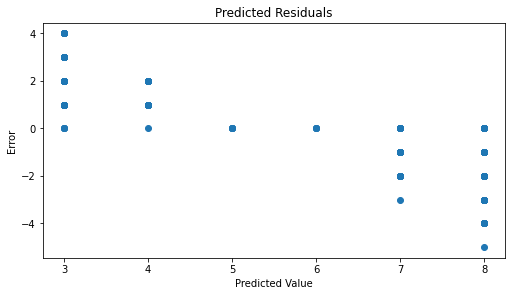

In [26]:
how = scores_df.loc['red_Naive Bayes','tp']
helpers.eval.plot_residuals(d['y'], how)

# White modeling

### White preping

In [27]:
enc_w = helpers.prep.train_onehot_encoder(tw, config_obj['cat_feats'])


In [28]:
def onehot_encode_frame(df, feats, encoder):
    temp = encoder.transform(df[feats])
    cats = pd.DataFrame(temp.todense(),columns = encoder.get_feature_names_out())
    xf = pd.concat([df.drop(columns=feats), cats.set_index(df.index)], axis=1)
    return xf


In [29]:
temp = onehot_encode_frame(tw, config_obj['cat_feats'], enc_w)

In [30]:
temp = temp.drop(columns=['type', 'quality'])

In [31]:
scale_w = helpers.prep.train_scaler(temp)

In [32]:
m_tw = prep_frame(tw, enc_w, scale_w, config_obj)
m_vw = prep_frame(vw, enc_w, scale_w, config_obj)

### White training

In [33]:
models_w = {
    "Mode" : BaselineModel(method='mode'),
    # "KNN - 3": KNeighborsClassifier(n_neighbors=3),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear SVM": SVC(C=0.025, kernel="linear"),
    "RBF SVM": SVC(C=1, gamma=2),
    # "Gaussian Process": GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1)),
    # "Decision Tree": DecisionTreeClassifier(max_depth=5),
    # "Random Forest": RandomForestClassifier(max_depth=5, max_features=1, n_estimators=10),
    # "XG Boost": XGBClassifier(),
    # "XGRF": XGBRFClassifier(),
    "Neural Net": MLPClassifier(alpha=1, max_iter=1000),
    "AdaBoost": AdaBoostClassifier(),
    "Naive Bayes": GaussianNB(),
    # "QDA": QuadraticDiscriminantAnalysis(),
    }

for k in range(1,16):
    models_w[f"KNN_{k}"] = KNeighborsClassifier(n_neighbors=k)
for k in range(1,16):
    models_w[f'Decision Tree_{k}'] = DecisionTreeClassifier(max_depth=k)
for k in range(1,16):
    models_w[f"Random Forest_{k}"] = RandomForestClassifier(max_depth=k)

In [34]:
import time
for name, model in models_w.items():
    # time.sleep(1)
    start_time = time.time()
    model.fit(m_tw['X'], m_tw['y'])
    stop_time = time.time()
    # print(f'Fit {name} in {stop_time-start_time}')

### White scoring

In [35]:
m_tw['X'].columns , d['X'].columns

(Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
        'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
        'ph', 'sulphates', 'alcohol', 'flavor_profile_0', 'flavor_profile_1',
        'flavor_profile_2', 'flavor_profile_3', 'flavor_vinegar_noticeable',
        'flavor_vinegar_undetectable'],
       dtype='object'),
 Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
        'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
        'ph', 'sulphates', 'alcohol', 'flavor_profile_0', 'flavor_profile_1',
        'flavor_profile_2', 'flavor_profile_3', 'flavor_vinegar_noticeable',
        'flavor_vinegar_strong', 'flavor_vinegar_undetectable'],
       dtype='object'))

In [36]:
from sklearn.metrics import accuracy_score, mean_squared_error, max_error
scores = {}
for name, model in models_w.items():
    # time.sleep(1)
    start_time = time.time()
    tp = model.predict(m_tw['X'])
    vp = model.predict(m_vw['X'])
    scores[f'white_{name}'] = {
        'train_acc': accuracy_score(m_tw['y'], tp),
        'validate_acc': accuracy_score(m_vw['y'], vp),
        'train_rmse' : mean_squared_error(m_tw['y'], tp, squared=False),
        'validate_rmse' : mean_squared_error(m_vw['y'], vp, squared=False),
        'train_max_error': max_error(m_tw['y'], tp),
        'validate_max_error': max_error(m_vw['y'], vp),
        'tp': tp,
        'vp': vp
    }
    stop_time = time.time()
    # print(f'{name} predicted in {stop_time-start_time}')

In [37]:
scores_df_w = pd.DataFrame.from_dict(scores, orient='index')
scores_df_w.shape

(52, 8)

In [38]:
scores_df_w.sort_values('validate_rmse', ascending=True)

,train_acc,validate_acc,train_rmse,validate_rmse,train_max_error,validate_max_error,tp,vp
white_Random Forest_10,0.848064,0.582598,0.494498,0.766578,3,3,"[6, 6, 7, 7, 7, 7, 6, 6, 6, 5, 7, 5, 6, 5, 6, ...","[5, 7, 6, 6, 7, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, ..."
white_Random Forest_7,0.675505,0.578815,0.695403,0.770680,3,3,"[6, 6, 6, 7, 7, 6, 6, 6, 6, 5, 7, 5, 6, 5, 7, ...","[5, 7, 6, 6, 7, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, ..."
white_Random Forest_15,0.994108,0.567465,0.091747,0.773945,2,3,"[6, 6, 7, 7, 7, 7, 7, 6, 6, 5, 7, 6, 6, 5, 6, ...","[5, 7, 6, 6, 7, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, ..."
white_Random Forest_12,0.944444,0.567465,0.314493,0.775573,3,3,"[6, 6, 7, 7, 7, 7, 7, 6, 6, 5, 7, 6, 6, 5, 6, ...","[5, 7, 6, 6, 7, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, ..."
white_Random Forest_8,0.729798,0.569987,0.651339,0.776385,3,3,"[6, 6, 7, 7, 7, 6, 6, 6, 6, 5, 7, 5, 6, 5, 6, ...","[5, 7, 6, 6, 7, 6, 6, 6, 6, 6, 5, 7, 6, 6, 6, ..."
white_Random Forest_14,0.988636,0.568726,0.145065,0.778008,3,3,"[6, 6, 7, 7, 7, 7, 7, 6, 6, 5, 7, 6, 6, 5, 6, ...","[5, 7, 6, 6, 7, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, ..."
white_Random Forest_9,0.795455,0.569987,0.572592,0.778818,3,3,"[6, 6, 7, 7, 7, 5, 6, 6, 6, 5, 7, 5, 6, 5, 6, ...","[5, 7, 6, 6, 7, 6, 6, 6, 6, 6, 5, 7, 6, 6, 6, ..."
white_Random Forest_13,0.965488,0.558638,0.243605,0.782855,3,4,"[6, 6, 7, 7, 7, 7, 7, 6, 6, 5, 7, 6, 6, 5, 6, ...","[5, 7, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ..."
white_Random Forest_6,0.633418,0.564943,0.734262,0.784465,3,3,"[6, 6, 6, 7, 6, 6, 6, 6, 6, 5, 7, 5, 6, 5, 6, ...","[5, 7, 6, 6, 7, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, ..."
white_Random Forest_11,0.900253,0.557377,0.409278,0.790868,3,3,"[6, 6, 7, 7, 7, 7, 7, 6, 6, 5, 7, 6, 6, 5, 6, ...","[5, 7, 6, 6, 7, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, ..."
